# Exposure to drought


A simple accepted measure for drought is the Standardized Precipitation Index (SPI). Similar to indicators 1.1 and 1.2, this indicator is not a direct measure of health impacts of drought, but rather a measure of the risk factor, which is mediated by a range of complicated causes to health. In general, the claim is that increase in this indicator represents an increased risk, which may lead directly to negative impacts on health or require adaptation measures to mitigate negative impacts.



| SPI  A+S   | SPI Agnew| Category         |
|------------|----------|------------------|
|  >-0.99    | >= -0.84 | Normal           | 
| -1.5 to -1 | < -0.84  | Moderate Drought |
| -1.5 to -2 | < -1.28  | Severe drought   | 
| < -2       | < -1.65  | Extreme drought  |



Select the locations experiencing 'Severe' drought. Define the drought indicator as 'number of months in drought' for a given year.

> NOTE use the -1.5 threshold since it was defined by WMO 2012 document


## Literature on selection of drought index

In 2009, the World Meteorological Organization (WMO) approved the Lincoln Declaration on Drought Indices (LDDI). The LDDI recommends that "the Standardized Precipitation Index (SPI) be used to characterize the meteorological droughts around the world", in addition to other drought indices that were in use in their service. In support of this recommendation, it was suggested that a "comprehensive user manual" describing the SPI should be developed. The manual provides a description of the index, the computation methods, specific examples of where it is currently being used, the strengths and limitations and mapping capabilities.

https://www.ncl.ucar.edu/Applications/spi.shtml

https://climatedataguide.ucar.edu/climate-data/standardized-precipitation-index-spi


Note this one also good for extreme rain

https://link.springer.com/chapter/10.1007/978-94-015-9265-9_2

## SPI drought index

> IMPORTANT: indication from publication (see other doc) that SPI and SPEI diverge due to temperatures. Looking at results the divergance is significant globally! This has implications on both the Lancet results directly and more generally on the use of SPI vs SPEI as an indicator of global prevalence of drought


Python code:

https://www.drought.gov/drought/python-climate-indices


## Data for SPI

Monthly summary data for PPT from ERA interim

Use PPT data from CRU https://crudata.uea.ac.uk/cru/data/hrg/ http://data.ceda.ac.uk//badc/cru/data/cru_ts/cru_ts_4.01/data/ which covers a much longer time period than ECMFW ERA Interim (but only at monthly scale, which is not enough for heatwaves and i think labour).


## Weighting indicator by population and by area

Initial calculation just did a drought count, but this ignores the relative size of the grid squares. A better approach could be to follow https://www.nature.com/articles/s41598-017-14283-2 with 'area in drought' (would need to calculate the real rather than relative size of grid squares).

The question is then how to calculate the population impacted? One possibility is to simply calculate the number of people. This would NOT be directly comparable to the area in drought however. It would only be able to show the relative trends.


In [3]:
%matplotlib inline

In [4]:
from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt


from cartopy import crs

from scipy import stats
from tqdm import tqdm_notebook

from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [10]:
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

# For CRU data we only go to 2016 for now. Address this in future versions...
MAX_YEAR = 2017

POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'
# POP_FILE = POP_DATA_SRC / 'population_count_2000-2020_eightres.nc'
# COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

RESULTS_FOLDER = Path('./results/lancet2019/1.4 drought')
# RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'drought'/ 'results_2019'
# INTERMEDIATE_RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

EXTREME_DROUGHT_THRESHOLD = -1.5

COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpwv4/gpw_v4_national_identifier_lookup.txt'
COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'


# SPI_INPUT_FILE = DATA_SRC / 'lancet' / 'spi_calculations' / 'spi6_1901_2017_cru.nc'
# SPI_PROJ_OUT = DATA_SRC / 'lancet' / 'spi_calculations' / 'spi6_projected'
# SPI_PROJ_OUT.mkdir(exist_ok=True)

In [8]:
event_counts = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / 'drought_event_counts.nc').spi6

In [11]:
COUNTRIES_RASTER = xr.open_dataset(COUNTRY_RASTER_FILES).load()
COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')

In [12]:
population = xr.open_dataarray(POPULATION_FILE)

## Project the drought counts to the population to get the drought exposure

In [14]:
drought_count_exposures = event_counts * population

In [24]:
# Note: for the exposures, no need to re-project because we don't need to normalise by country population.
# The totals are fine.
exposure_results = []
    
for _, row in tqdm_notebook(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    grid_code = row.GRIDCODE
    country_mask = COUNTRIES_RASTER.country_codes == grid_code

    country_exposures_ts = (drought_count_exposures * country_mask).sum(dim=['latitude', 'longitude'])

    exposure_results.append(country_exposures_ts.to_dataframe(row.ISOCODE))

exposure_results = pd.concat(exposure_results, axis=1)

In [45]:
# Save excel 
with pd.ExcelWriter(RESULTS_FOLDER / f'droughts_n_exposure_change_2000-{MAX_YEAR}.xlsx', mode='w') as writer:
    exposure_results.to_excel(writer, sheet_name='countries_droughts exposures')

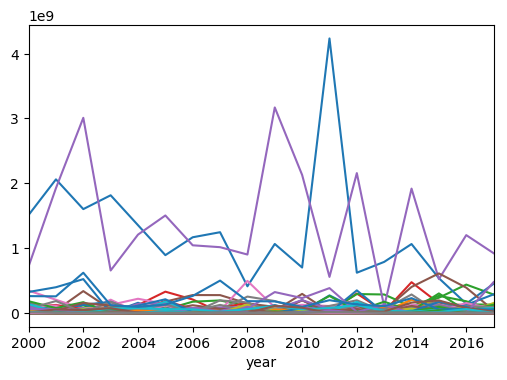

In [31]:
exposure_results.plot(legend=False)

# Save the drought counts as text files

In [18]:
COUNTS_CSV_FOLDER = RESULTS_FOLDER / 'count_maps_as_tables'
COUNTS_CSV_FOLDER.mkdir(exist_ok=True)

In [19]:
for year in range(2000, MAX_YEAR+1):
    counts_table = event_counts.sel(year=year).to_dataframe('droughts_counts').dropna().reset_index()
    counts_table.to_csv(COUNTS_CSV_FOLDER/ f'{year}_droughts_counts.csv', index=False)

# Save the drought exposures as text files

In [16]:
EXPOSURES_CSV_FOLDER = RESULTS_FOLDER / 'exposure_maps_as_tables'
EXPOSURES_CSV_FOLDER.mkdir(exist_ok=True)

In [17]:
for year in range(2000, MAX_YEAR+1):
    exposures_table = drought_count_exposures.sel(year=year).to_dataframe('droughts_exposures').dropna().reset_index()
    exposures_table.to_csv(EXPOSURES_CSV_FOLDER/ f'{year}_droughts_exposures.csv', index=False)